# Predicting Crypto prices
1. Get historic stock prices
2. Extract prices to predict
3. Normalise
4. Create Time Series
5. Build model
6. Fit model
7. Test and evaluate

# X and Y
X = Goes back looking over a series of time e.g. past 7 minutes.<br>
Y = The last nth of the series of time e.g. the price of BTC on the 7th minute of the past 7 minutes.<br>

In [1]:
# Example
"""
look_back = 3
data = [1,2,4,5,7,8,9]

   X      Y
[1,2,4]->[5]
[2,4,5]->[7]
[4,5,7]->[8]
[5,7,8]->[9]
"""

'\nlook_back = 3\ndata = [1,2,4,5,7,8,9]\n\n   X      Y\n[1,2,4]->[5]\n[2,4,5]->[7]\n[4,5,7]->[8]\n[5,7,8]->[9]\n'

# Import dependencies

In [2]:
# install dependencies
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator

# Load dataset

In [3]:
# 1. Get historic stock prices
def allData():
    path = '../datasets/BTC/'
    
    ori_df = pd.read_csv(f"{path}gemini_BTCUSD_2015_1min.csv")
    for item in range(2016, 2022):
        df = pd.read_csv(f"{path}/gemini_BTCUSD_{item}_1min.csv")
        new_df = pd.concat([ori_df, df], ignore_index=True)
        ori_df = new_df

    ori_df.rename({"Unix Timestamp": "Timestamp"}, axis=1, inplace=True)
    combine_df = ori_df
    combine_df.drop_duplicates(subset=["Timestamp"], keep='first', inplace=True)
    
    return combine_df

data = allData()

# Explore dataset

In [4]:
data.head()

,Timestamp,Date,Symbol,Open,High,Low,Close,Volume
0,1451606340,2015-12-31 23:59:00,BTCUSD,429.95,429.95,429.95,429.95,0.0
1,1451606280,2015-12-31 23:58:00,BTCUSD,429.95,429.95,429.95,429.95,0.0
2,1451606220,2015-12-31 23:57:00,BTCUSD,429.95,429.95,429.95,429.95,0.0
3,1451606160,2015-12-31 23:56:00,BTCUSD,429.95,429.95,429.95,429.95,0.0
4,1451606100,2015-12-31 23:55:00,BTCUSD,429.95,429.95,429.95,429.95,0.0


In [5]:
data.tail()

,Timestamp,Date,Symbol,Open,High,Low,Close,Volume
3050922,1609459440000,2021-01-01 00:04:00,BTCUSD,29056.21,29056.21,29046.04,29048.46,0.032502
3050923,1609459380000,2021-01-01 00:03:00,BTCUSD,29057.27,29057.27,29028.69,29056.21,0.049909
3050924,1609459320000,2021-01-01 00:02:00,BTCUSD,29085.38,29086.14,29043.25,29057.27,5.075271
3050925,1609459260000,2021-01-01 00:01:00,BTCUSD,29033.01,29086.14,29033.01,29085.38,1.451389
3050926,1609459200000,2021-01-01 00:00:00,BTCUSD,28979.74,29033.01,28956.18,29033.01,0.126441


In [6]:
data.columns

Index(['Timestamp', 'Date', 'Symbol', 'Open', 'High', 'Low', 'Close',
       'Volume'],
      dtype='object')

In [7]:
data = data.drop(columns=['Timestamp', 'Symbol', 'Open', 'High', 'Low', 'Volume'])

In [8]:
data.shape

(3050927, 2)

In [9]:
data.describe()

,Close
count,3.050927e+06
mean,1.089529e+04
std,1.427358e+04
min,2.360000e+02
25%,1.178570e+03
50%,6.765350e+03
75%,1.042789e+04
max,6.489000e+04


In [10]:
data.dtypes

Date      object
Close    float64
dtype: object

In [11]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_axis(data['Date'], inplace=True)
data.set_index('Date', inplace=True)

In [12]:
data.sort_index(inplace=True)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3050927 entries, 2015-10-08 13:40:00 to 2021-10-08 00:04:00
Data columns (total 1 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Close   float64
dtypes: float64(1)
memory usage: 46.6 MB


In [14]:
data

,Close
Date,
2015-10-08 13:40:00,242.50
2015-10-08 13:41:00,242.95
2015-10-08 13:42:00,242.95
2015-10-08 13:43:00,242.96
2015-10-08 13:44:00,242.96
...,...
2021-10-08 00:00:00,53841.33
2021-10-08 00:01:00,53857.19
2021-10-08 00:02:00,53779.86


# Data visualisation

In [15]:
import matplotlib.pyplot as plt

In [16]:
data['Close']

Date
2015-10-08 13:40:00      242.50
2015-10-08 13:41:00      242.95
2015-10-08 13:42:00      242.95
2015-10-08 13:43:00      242.96
2015-10-08 13:44:00      242.96
                         ...   
2021-10-08 00:00:00    53841.33
2021-10-08 00:01:00    53857.19
2021-10-08 00:02:00    53779.86
2021-10-08 00:03:00    53744.05
2021-10-08 00:04:00    53823.93
Name: Close, Length: 3050927, dtype: float64

In [17]:
data_close = data['Close'].values
data_close

array([  242.5 ,   242.95,   242.95, ..., 53779.86, 53744.05, 53823.93])

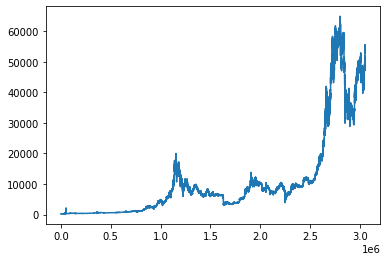

In [18]:
data_close = data_close.reshape((-1, 1))
plt.plot(data_close)
plt.show()

# Split data into train and test

In [19]:
train_size = int(len(data_close) * 0.8) # 80% of data will be for training

data_train = data_close[:train_size]
data_test = data_close[train_size:] # the rest will be for testing

print('Train data size: ', len(data_train))
print('Test data size: ', len(data_test))

Train data size:  2440741
Test data size:  610186


# Create time series out of data

In [20]:
look_back = 15 # look back to the past 60 minutes (one hour) of the prices

train_generator = TimeseriesGenerator(data_train, data_train, length=look_back, batch_size=64)     
test_generator = TimeseriesGenerator(data_test, data_test, length=look_back, batch_size=1)

# Set up and build LSTM model

In [21]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.regularizers import L2

In [22]:
# initialise model
model = Sequential()
# add layers
model.add(LSTM(5, activation='relu', input_shape=(look_back, 1)))
model.add(Dropout(0.5, input_shape=(look_back, 1)))
model.add(Dense(1))
# compile model
model.compile(loss='mse', optimizer='adam')

In [23]:
# fit the model
num_epochs = 11
model.fit(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/11
38137/38137 [==============================] - 122s 3ms/step - loss: 40684180.0000
Epoch 2/11
38137/38137 [==============================] - 122s 3ms/step - loss: 40386696.0000
Epoch 3/11
38137/38137 [==============================] - 129s 3ms/step - loss: 40091600.0000
Epoch 4/11
38137/38137 [==============================] - 117s 3ms/step - loss: 39799876.0000
Epoch 5/11
38137/38137 [==============================] - 129s 3ms/step - loss: 39508560.0000
Epoch 6/11
38137/38137 [==============================] - 140s 4ms/step - loss: 39219896.0000
Epoch 7/11
38137/38137 [==============================] - 135s 4ms/step - loss: 38933448.0000
Epoch 8/11
38137/38137 [==============================] - 134s 4ms/step - loss: 38650932.0000
Epoch 9/11
38137/38137 [==============================] - 130s 3ms/step - loss: 38371100.0000
Epoch 10/11
38137/38137 [==============================] - 132s 3ms/step - loss: 38092032.0000
Epoch 11/11
38137/38137 [==============================] - 

In [24]:
prediction = model.predict(test_generator)

data_train = data_train.reshape((-1))
data_test = data_test.reshape((-1))
prediction = prediction.reshape((-1))

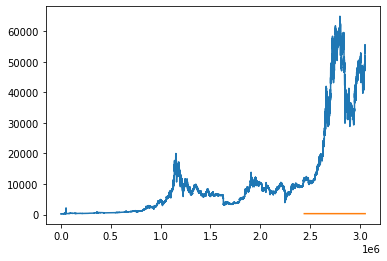

In [25]:
# Plot the predictions on a graph
prediction_plot = np.empty_like(data_close.reshape((-1)))
prediction_plot[:] = np.nan
prediction_plot[(len(data_train) + look_back):] = prediction

plt.plot(data_close)
plt.plot(prediction_plot)
plt.show()

# Make forecast

In [26]:
data_close = data_close.reshape((-1))

def predict(num_prediction, model):
    prediction_list = data_close[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list

num_prediction = 100
forecast = predict(num_prediction, model)

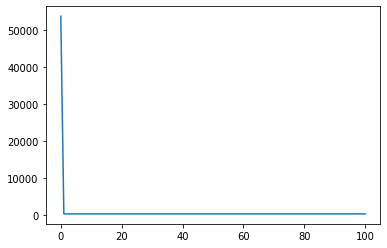

In [27]:
forecast = forecast.reshape((-1))
plt.plot(forecast)
plt.show()

In [28]:
data_forecast = np.append(data_close, forecast)

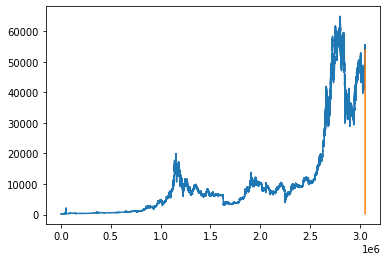

In [29]:
# Plot the predictions on a graph
forecast_plot = np.empty_like(data_forecast)
forecast_plot[:] = np.nan
forecast_plot[len(data_close):] = forecast

plt.plot(data_close)
plt.plot(forecast_plot)
plt.show()